In [55]:
import gc
import multiprocessing
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
# import lightgbm as lgb
# from tqdm import tqdm_notebook

In [94]:
df = pd.read_csv("../curated-data/ModelData.csv")
df.head(5)

,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,Task,...,BR,NP,SR,AP,AR,DWH,DWR,T,DS,Rank
0,24,38,2,8,10,3,8,16,17,26,...,2,2,Successful,2,4,3,70,1,2,2
1,17,35,6,9,7,4,8,25,14,31,...,2,2,Successful,2,5,2,70,2,2,1
2,16,54,3,7,3,9,6,23,24,16,...,1,2,Unsuccessful,3,2,3,60,2,3,0
3,18,28,6,4,10,3,8,13,12,35,...,1,1,Successful,3,5,1,60,3,2,2
4,15,42,7,8,10,8,10,22,16,30,...,2,2,Unsuccessful,3,4,3,80,3,3,1


In [95]:
df['NASA'] = np.log(df['NASA'] + .001)
df['TA'] = np.log(df['TA'] + .001)
df['DWR'] = np.log(df['DWR'] + .001)
df['EM'] = np.log(df['EM'])
df['Task'] = np.log(df['Task'])
df.head(5)

,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,Task,...,BR,NP,SR,AP,AR,DWH,DWR,T,DS,Rank
0,3.178095,3.637612,2,8,10,3,8,16,2.833213,3.258097,...,2,2,Successful,2,4,3,4.248510,1,2,2
1,2.833272,3.555377,6,9,7,4,8,25,2.639057,3.433987,...,2,2,Successful,2,5,2,4.248510,2,2,1
2,2.772651,3.989003,3,7,3,9,6,23,3.178054,2.772589,...,1,2,Unsuccessful,3,2,3,4.094361,2,3,0
3,2.890427,3.332240,6,4,10,3,8,13,2.484907,3.555348,...,1,1,Successful,3,5,1,4.094361,3,2,2
4,2.708117,3.737693,7,8,10,8,10,22,2.772589,3.401197,...,2,2,Unsuccessful,3,4,3,4.382039,3,3,1


In [96]:
# Printing df 
df

,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,Task,...,BR,NP,SR,AP,AR,DWH,DWR,T,DS,Rank
0,3.178095,3.637612,2,8,10,3,8,16,2.833213,3.258097,...,2,2,Successful,2,4,3,4.248510,1,2,2
1,2.833272,3.555377,6,9,7,4,8,25,2.639057,3.433987,...,2,2,Successful,2,5,2,4.248510,2,2,1
2,2.772651,3.989003,3,7,3,9,6,23,3.178054,2.772589,...,1,2,Unsuccessful,3,2,3,4.094361,2,3,0
3,2.890427,3.332240,6,4,10,3,8,13,2.484907,3.555348,...,1,1,Successful,3,5,1,4.094361,3,2,2
4,2.708117,3.737693,7,8,10,8,10,22,2.772589,3.401197,...,2,2,Unsuccessful,3,4,3,4.382039,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,3.258135,3.555377,4,7,7,5,8,23,2.639057,3.401197,...,1,2,Successful,3,5,1,2.302685,3,1,1
350,2.995782,3.663587,10,10,9,5,6,19,2.564949,3.178054,...,2,3,Unsuccessful,3,2,3,4.499821,3,2,0
351,2.639129,3.401231,4,8,7,6,10,13,2.484907,3.295837,...,2,2,Unsuccessful,2,5,3,4.382039,1,3,2
352,3.258135,3.555377,6,8,7,6,6,18,2.944439,3.367296,...,1,3,Unsuccessful,1,5,3,4.499821,2,1,1


In [97]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['SR']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [90]:
X_train

,NASA,TA,EXT,AGR,CS,NT,OP,AV,EM,Task,...,TWR,BR,NP,AP,AR,DWH,DWR,T,DS,Rank
348,1.791926,3.850169,6,6,6,6,6,7,7,7,...,0,1,1,3,1,1,-6.907755,1,1,0
338,2.833272,4.043069,9,6,9,8,5,21,25,23,...,20,2,1,2,4,3,3.912043,1,3,1
299,3.091088,4.043069,6,7,10,4,8,20,25,28,...,30,2,1,3,4,3,3.688904,2,3,1
115,2.833272,3.526390,8,5,9,4,8,19,17,31,...,30,1,2,3,2,3,3.912043,3,3,2
113,3.044570,3.828663,3,7,9,6,10,17,16,26,...,50,1,1,1,5,2,4.248510,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,3.091088,3.583547,9,9,10,3,9,24,24,32,...,70,2,2,2,5,1,4.248510,3,1,1
70,2.639129,3.891841,3,4,10,8,8,9,10,28,...,30,1,2,3,4,3,4.094361,1,3,2
230,2.995782,4.025370,4,4,6,9,8,22,25,21,...,40,1,2,3,2,2,3.688904,3,3,1
47,2.944492,3.806685,5,7,9,8,6,17,26,27,...,40,1,1,1,5,3,4.248510,2,3,1


In [61]:
# from sklearn.preprocessing import StandardScaler
# X_train_Std = StandardScaler().fit_transform(X_train)
# X_test_Std = StandardScaler().fit_transform(X_test)

In [98]:
%%time
from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, Y_train)

Wall time: 118 ms


RandomForestClassifier(max_depth=2, random_state=0)

In [99]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
NP,0.237020
H,0.140289
TA,0.087921
NASA,0.076907
DWH,0.070232
Rank,0.061361
EM,0.057092
Task,0.036192
EXT,0.028682
OP,0.027577


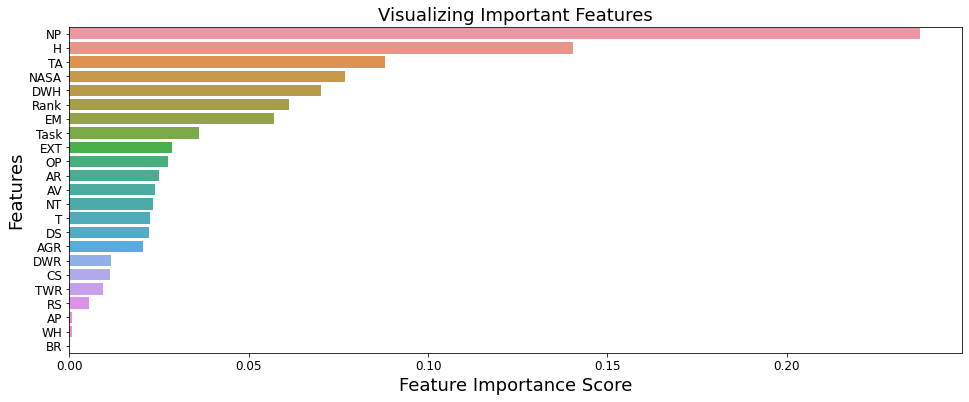

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()

In [102]:
y_pred = rf.predict(X_test_Std)
y_score = rf.predict_proba(X_test_Std)

In [80]:
y_score

array([[0.53617441, 0.46382559],
       [0.29768943, 0.70231057],
       [0.28433257, 0.71566743],
       [0.36881798, 0.63118202],
       [0.29931427, 0.70068573],
       [0.25137212, 0.74862788],
       [0.22004925, 0.77995075],
       [0.27598401, 0.72401599],
       [0.19987004, 0.80012996],
       [0.31669689, 0.68330311],
       [0.23153916, 0.76846084],
       [0.2657241 , 0.7342759 ],
       [0.20840275, 0.79159725],
       [0.38369905, 0.61630095],
       [0.377762  , 0.622238  ],
       [0.35983772, 0.64016228],
       [0.50076316, 0.49923684],
       [0.29653149, 0.70346851],
       [0.50631081, 0.49368919],
       [0.43757106, 0.56242894],
       [0.22040457, 0.77959543],
       [0.4869917 , 0.5130083 ],
       [0.26556203, 0.73443797],
       [0.36934207, 0.63065793],
       [0.44189998, 0.55810002],
       [0.41585407, 0.58414593],
       [0.30736139, 0.69263861],
       [0.3439347 , 0.6560653 ],
       [0.4594997 , 0.5405003 ],
       [0.57989452, 0.42010548],
       [0.

In [103]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.676056338028169


In [104]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score

accuracyScore = accuracy_score(Y_test, y_pred)
# f1Score = f1_score(Y_test, y_pred, zero_division=1)
aucScore = roc_auc_score(Y_test, y_score[:,1])

print(accuracyScore)
print(aucScore)

0.676056338028169
0.5896739130434783


In [105]:
df_buffered = df[['NP', 'H', 'TA', 'NASA', 'DWH', 'Rank', 'EM', 'Task', 'SR']].copy()
df_buffered

,NP,H,TA,NASA,DWH,Rank,EM,Task,SR
0,2,3.713596,3.637612,3.178095,3,2,2.833213,3.258097,Successful
1,2,3.218916,3.555377,2.833272,2,1,2.639057,3.433987,Successful
2,2,2.833272,3.989003,2.772651,3,0,3.178054,2.772589,Unsuccessful
3,1,4.094361,3.332240,2.890427,1,2,2.484907,3.555348,Successful
4,2,3.044570,3.737693,2.708117,3,1,2.772589,3.401197,Unsuccessful
...,...,...,...,...,...,...,...,...,...
349,2,3.178095,3.555377,3.258135,1,1,2.639057,3.401197,Successful
350,3,2.397986,3.663587,2.995782,3,0,2.564949,3.178054,Unsuccessful
351,2,4.234121,3.401231,2.639129,3,2,2.484907,3.295837,Unsuccessful
352,3,3.135538,3.555377,3.258135,3,1,2.944439,3.367296,Unsuccessful


In [109]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_buffered, df['SR']):
    strat_train_set = df_buffered.loc[train_index]
    strat_test_set = df_buffered.loc[test_index]

X_train = strat_train_set.drop('SR', axis=1)
Y_train = strat_train_set['SR'].copy()

X_test = strat_test_set.drop('SR', axis=1)
Y_test = strat_test_set['SR'].copy()

In [110]:
%%time
from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, Y_train)

Wall time: 111 ms


RandomForestClassifier(max_depth=2, random_state=0)

In [111]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
NP,0.238631
H,0.186518
TA,0.123688
NASA,0.121035
DWH,0.112807
EM,0.111054
Task,0.062464
Rank,0.043804


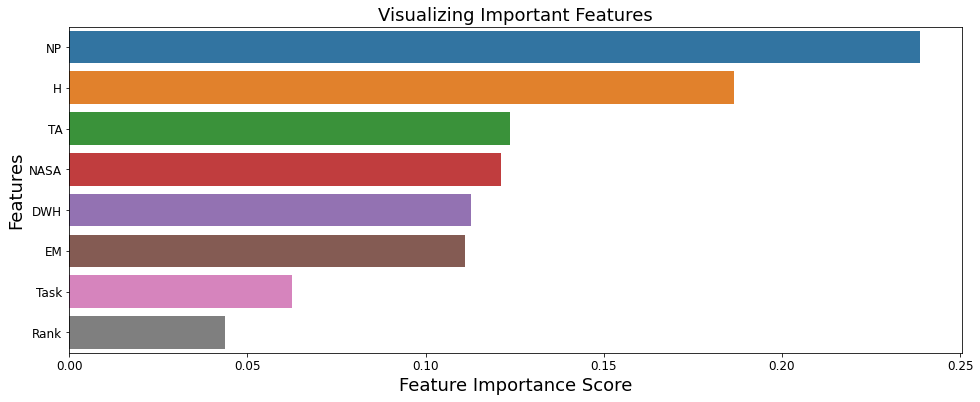

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
# Creating a bar plot
plt.figure(figsize=(16, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.title("Visualizing Important Features", fontsize=18)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
# plt.legend()
plt.show()

In [115]:
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)

In [116]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.6619718309859155


In [117]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score

accuracyScore = accuracy_score(Y_test, y_pred)
# f1Score = f1_score(Y_test, y_pred, zero_division=1)
aucScore = roc_auc_score(Y_test, y_score[:,1])

print(accuracyScore)
print(aucScore)

0.6619718309859155
0.6413043478260869
